# Import libraries

In [67]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 
from tqdm import tqdm 
import numpy as np
from sklearn.preprocessing import StandardScaler

# Load datasets into a dataframe

load & print shapes

In [2]:
trainset = pd.read_csv('/content/aps_failure_training_set.csv', skiprows=19)
testset = pd.read_csv('/content/aps_failure_test_set.csv', skiprows=19)
trainset.shape, testset.shape

((60000, 171), (16000, 171))

Print some examples

In [3]:
trainset.head()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,76698,na,2130706438,280,0,0,0,0,0,...,1240520,493384,721044,469792,339156,157956,73224,0,0,0
1,neg,33058,na,0,na,0,0,0,0,0,...,421400,178064,293306,245416,133654,81140,97576,1500,0,0
2,neg,41040,na,228,100,0,0,0,0,0,...,277378,159812,423992,409564,320746,158022,95128,514,0,0
3,neg,12,0,70,66,0,10,0,0,0,...,240,46,58,44,10,0,0,0,4,32
4,neg,60874,na,1368,458,0,0,0,0,0,...,622012,229790,405298,347188,286954,311560,433954,1218,0,0


# Pre-Processing Trainset

The dataset contians `na` as a missing value, we will change it by `np.nan`.

In [4]:
trainset.replace('na', np.nan, inplace=True)

Check if the dataset contains duplicates

In [5]:
num_duplicated = len(trainset[trainset.duplicated()])
print(f'STATUS: There are/is {num_duplicated} duplicated rows')

STATUS: There are/is 0 duplicated rows


Check if the dataset contains null values in class column

In [6]:
if not trainset['class'].isna().any():
    print('STATUS: There is no null value in class column')
    print(trainset['class'].value_counts())
else:
    print(f'STATUS: There are/is {len(trainset[trainset["class"].isna()])} null value in class column')

STATUS: There is no null value in class column
neg    59000
pos     1000
Name: class, dtype: int64


Count of clumns that contians null values

In [7]:
columns_with_null_values = 0
for column in trainset.columns:
    if trainset[column].isna().any():
        columns_with_null_values += 1
print(f'STATUS: {columns_with_null_values}/{len(trainset.columns)} columns contains null values')

STATUS: 169/171 columns contains null values


Count of null value per column

In [8]:
p_of_null = {
    'column': [],
    'count_of_null':[],
    'p_of_null': []
}

for column in trainset.columns[1:]:
    p_of_null['column'].append(column)
    p_of_null['count_of_null'].append(trainset[column].isna().sum())
    p_of_null['p_of_null'].append(trainset[column].isna().mean() * 100)

df_p_of_null = pd.DataFrame(p_of_null)
df_p_of_null.sort_values('p_of_null', inplace=True)
df_p_of_null

,column,count_of_null,p_of_null
0,aa_000,0,0.000000
80,bt_000,167,0.278333
96,ck_000,338,0.563333
95,cj_000,338,0.563333
94,ci_000,338,0.563333
...,...,...,...
112,cr_000,46329,77.215000
75,bo_000,46333,77.221667
76,bp_000,47740,79.566667
77,bq_000,48722,81.203333


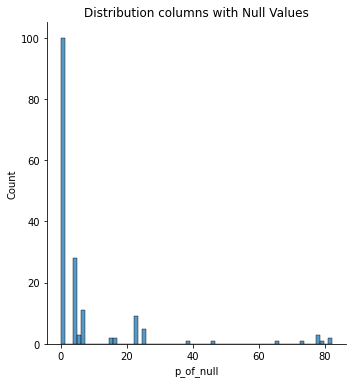

In [9]:
variable = df_p_of_null['p_of_null'].values
ax = sns.displot(variable)
plt.title('Distribution columns with Null Values')
plt.xlabel('p_of_null')
plt.show()

We will remove columns that has more than 50% of null values

In [10]:
columns_to_drop = df_p_of_null[df_p_of_null.p_of_null >= 50].column
columns_to_drop

73     bm_000
74     bn_000
1      ab_000
112    cr_000
75     bo_000
76     bp_000
77     bq_000
78     br_000
Name: column, dtype: object

In [11]:
trainset.drop(columns_to_drop, axis=1, inplace=True)
trainset

,class,aa_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,76698,2130706438,280,0,0,0,0,0,0,...,1240520,493384,721044,469792,339156,157956,73224,0,0,0
1,neg,33058,0,NaN,0,0,0,0,0,0,...,421400,178064,293306,245416,133654,81140,97576,1500,0,0
2,neg,41040,228,100,0,0,0,0,0,0,...,277378,159812,423992,409564,320746,158022,95128,514,0,0
3,neg,12,70,66,0,10,0,0,0,318,...,240,46,58,44,10,0,0,0,4,32
4,neg,60874,1368,458,0,0,0,0,0,0,...,622012,229790,405298,347188,286954,311560,433954,1218,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,neg,153002,664,186,0,0,0,0,0,2564,...,998500,566884,1290398,1218244,1019768,717762,898642,28588,0,0
59996,neg,2286,2130706538,224,0,0,0,0,0,0,...,10578,6760,21126,68424,136,0,0,0,0,0
59997,neg,112,2130706432,18,0,0,0,0,0,0,...,792,386,452,144,146,2622,0,0,0,0
59998,neg,80292,2130706432,494,0,0,0,0,0,0,...,699352,222654,347378,225724,194440,165070,802280,388422,0,0


Class balance

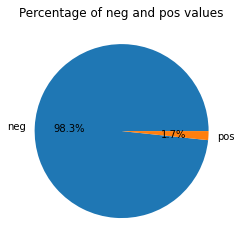

In [12]:
# count the frequency of each value in the series
counts = trainset['class'].value_counts()

# calculate the percentage of each value in the series
percentages = counts / len(trainset['class']) * 100

# create a pie chart to show the percentages
labels = percentages.index.tolist()
plt.pie(percentages, labels=labels, autopct='%1.1f%%')
plt.title('Percentage of neg and pos values')
plt.show()

Count of columns per dtype

In [13]:
X_train_df = trainset.drop('class', axis=1)
y_train_df = trainset[['class']]

int_cols = []
float_cols = []
object_cols = []
for col in tqdm(X_train_df.columns):
    try:
        X_train_df[col] = pd.to_numeric(X_train_df[col])
        if (X_train_df[col] % 1 > 0).any(): float_cols.append(col)
        else: int_cols.append(col)
    except: object_cols.append(col)

100%|██████████| 162/162 [00:18<00:00,  8.76it/s]


In [14]:
print('int_cols:', len(int_cols))
print('float_cols:', len(float_cols))
print('object_cols:', len(object_cols))

int_cols: 157
float_cols: 5
object_cols: 0


Calcuate skew value to decide how impute missing values
- if skew >= -0.05 and skew <= 0.05: Normal distribution, impute with Mean
- if skew < -0.05 and skew > 0.05: left/right skewed distribution, impute with Median (for Numerical variables) or Mode (for categorical variables)

In [15]:
sr_skew = X_train_df.skew(axis=0, skipna=True)
df_skew = pd.DataFrame({'skew_value': sr_skew})
df_skew

,skew_value
aa_000,6.115752
ac_000,1.784845
ad_000,212.459406
ae_000,90.588252
af_000,51.671770
...,...
ee_007,15.717250
ee_008,13.426265
ee_009,29.214135
ef_000,73.432440


Columns with normal distribution

In [16]:
normal_dis = list(df_skew[(df_skew.skew_value <= 0.05) & (-0.5 <= df_skew.skew_value)].index)
print(len(normal_dis), 'column/s')

1 column/s


In [17]:
X_train_df[normal_dis].describe()

,cd_000
count,59324.0
mean,1209600.0
std,0.0
min,1209600.0
25%,1209600.0
50%,1209600.0
75%,1209600.0
max,1209600.0


This column that has a normal distribution contains one single value. So we will remove it.

In [18]:
X_train_df.drop(normal_dis, axis=1, inplace=True)

Columns with left/right skewed distribution

In [19]:
left_right_sk = list(df_skew[(df_skew.skew_value > 0.05) & (-0.5 < df_skew.skew_value)].index)
print(len(left_right_sk), 'column/s')

161 column/s


Impute missing values of Categorical variables with Mode

In [58]:
CAT_COLUMNS = []
d = []
for col in X_train_df.columns:
    d.append(len(X_train_df[col].unique()))

df = pd.DataFrame({'col':X_train_df.columns, 'unique_count':d})

bench = df['unique_count'].quantile(0.10)
print(bench)

for col in X_train_df.columns:
    if len(X_train_df[col].unique()) < bench:
        CAT_COLUMNS.append(col)

df_cat = X_train_df[CAT_COLUMNS]
df_cat = df_cat.fillna(df_cat.mode().iloc[0])
df_cat

264.0


,ag_000,ak_000,ar_000,as_000,au_000,ch_000,cs_009,db_000,dj_000,dk_000,dl_000,dm_000,dz_000,ea_000,ef_000,eg_000
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,32.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
59996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
59997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
59998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Impute missing values of Numerical variables with Median

In [59]:
df_num = X_train_df.drop(CAT_COLUMNS, axis=1)
df_num = df_num.fillna(df_num.median().iloc[0])
df_num

,aa_000,ac_000,ad_000,ae_000,af_000,ag_001,ag_002,ag_003,ag_004,ag_005,...,ee_000,ee_001,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009
0,76698,2.130706e+09,280.0,0.0,0.0,0.0,0.0,0.0,37250.0,1432864.0,...,965866.0,1706908.0,1240520.0,493384.0,721044.0,469792.0,339156.0,157956.0,73224.0,0.0
1,33058,0.000000e+00,30776.0,0.0,0.0,0.0,0.0,0.0,18254.0,653294.0,...,664504.0,824154.0,421400.0,178064.0,293306.0,245416.0,133654.0,81140.0,97576.0,1500.0
2,41040,2.280000e+02,100.0,0.0,0.0,0.0,0.0,0.0,1648.0,370592.0,...,262032.0,453378.0,277378.0,159812.0,423992.0,409564.0,320746.0,158022.0,95128.0,514.0
3,12,7.000000e+01,66.0,0.0,10.0,0.0,0.0,318.0,2212.0,3232.0,...,5670.0,1566.0,240.0,46.0,58.0,44.0,10.0,0.0,0.0,0.0
4,60874,1.368000e+03,458.0,0.0,0.0,0.0,0.0,0.0,43752.0,1966618.0,...,404740.0,904230.0,622012.0,229790.0,405298.0,347188.0,286954.0,311560.0,433954.0,1218.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,153002,6.640000e+02,186.0,0.0,0.0,0.0,0.0,2564.0,59100.0,1603216.0,...,1608808.0,1479066.0,998500.0,566884.0,1290398.0,1218244.0,1019768.0,717762.0,898642.0,28588.0
59996,2286,2.130707e+09,224.0,0.0,0.0,0.0,0.0,0.0,104.0,99186.0,...,13934.0,15024.0,10578.0,6760.0,21126.0,68424.0,136.0,0.0,0.0,0.0
59997,112,2.130706e+09,18.0,0.0,0.0,0.0,0.0,0.0,28.0,11592.0,...,15876.0,2740.0,792.0,386.0,452.0,144.0,146.0,2622.0,0.0,0.0
59998,80292,2.130706e+09,494.0,0.0,0.0,0.0,0.0,0.0,330.0,202498.0,...,1180714.0,1709450.0,699352.0,222654.0,347378.0,225724.0,194440.0,165070.0,802280.0,388422.0


Join Categorical and Numerical variables

In [60]:
X_train_filled = pd.concat([df_num, df_cat], axis=1)
X_train_filled.shape, X_train_filled.isna().any().any()

((60000, 161), False)

Label encoding

In [61]:
y_train_df_transformed = y_train_df['class'].map(lambda x: 1 if x == 'pos' else -1)
y_train_df_transformed.value_counts()

-1    59000
 1     1000
Name: class, dtype: int64

Extract X and y for training

In [73]:
X_train = X_train_filled.values
y_train = y_train_df_transformed.values

X_train.shape, y_train.shape

((60000, 161), (60000,))

In [74]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_train

array([[ 0.11938141,  2.31022415, -0.00430162, ..., -0.02861539,
        -0.02025676, -0.02353972],
       [-0.18069661, -0.43286155, -0.00343142, ..., -0.02861539,
        -0.02025676, -0.02353972],
       [-0.12581066, -0.43286125, -0.00430675, ..., -0.02861539,
        -0.02025676, -0.02353972],
       ...,
       [-0.40724039,  2.31022414, -0.00430909, ..., -0.02861539,
        -0.02025676, -0.02353972],
       [ 0.14409453,  2.31022414, -0.00429551, ..., -0.02861539,
        -0.02025676, -0.02353972],
       [-0.13143541, -0.43286065, -0.00429168, ..., -0.02861539,
        -0.02025676, -0.02353972]])

# Pre-Processing Testset

In [94]:
def preprocess_testset(testset):
    
    testset.replace("na", np.nan, inplace=True)
        
    testset = testset.drop(columns_to_drop, axis=1)
    testset = testset.drop(normal_dis, axis=1)

    X_test_df = testset.drop('class', axis=1)
    y_test_df = testset['class']

    df_cat_test = X_test_df[CAT_COLUMNS]
    df_cat_test = df_cat_test.fillna(df_cat_test.mode().iloc[0])
    df_cat_test = df_cat_test.astype(int)

    df_num_test = X_test_df.drop(CAT_COLUMNS, axis=1)
    df_num_test = df_num_test.fillna(df_num_test.median())
    df_num_test = df_num_test.astype(float)

    X_test_filled = df_num_test.join(df_cat_test)

    y_test_transformed = y_test_df.map(lambda x: 1 if x == 'pos' else -1)

    X_test_values = X_test_filled.values
    y_test_values = y_test_transformed.values

    X_scaled = scaler.fit_transform(X_test_values)
    
    return X_scaled, y_test_values

X_test, y_test = preprocess_testset(testset)

In [93]:
X_test.shape, y_test.shape

((16000, 161), (16000,))

# Feature Selection

In [107]:
from sklearn.feature_selection import SelectFromModel

In [114]:
selector = SelectFromModel(estimator=RandomForestClassifier(random_state=1)).fit(X_train, y_train)
selected_features = X_train_df.columns[selector.get_support()]
print(f'Number of selected features: {len(selected_features)}')

Number of selected features: 44


In [115]:
X_train_df[selected_features]

,aa_000,ag_000,ag_001,ag_002,ag_003,ag_009,ah_000,aj_000,ak_000,al_000,...,cj_000,cl_000,cn_006,cn_009,cp_000,db_000,dr_000,ds_000,du_000,dx_000
0,76698,0.0,0.0,0.0,0.0,0.0,2551696.0,0.0,0.0,0.0,...,0.00,6.0,1381362.0,1608.0,240.0,18.0,0.0,202710.0,14745580.0,0.0
1,33058,0.0,0.0,0.0,0.0,0.0,1393352.0,68.0,0.0,0.0,...,0.00,0.0,336388.0,56.0,0.0,NaN,0.0,103330.0,4510080.0,0.0
2,41040,0.0,0.0,0.0,0.0,0.0,1234132.0,0.0,0.0,0.0,...,0.00,0.0,196502.0,28.0,6.0,0.0,0.0,65772.0,300240.0,0.0
3,12,0.0,0.0,0.0,318.0,0.0,2668.0,0.0,0.0,642.0,...,0.00,2.0,152.0,0.0,2.0,0.0,370.0,48.0,15740.0,20174.0
4,60874,0.0,0.0,0.0,0.0,0.0,1974038.0,226.0,0.0,0.0,...,0.00,0.0,64230.0,86.0,212.0,0.0,0.0,149474.0,457040.0,98334.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,153002,0.0,0.0,0.0,2564.0,12560.0,4880368.0,280.0,0.0,1224.0,...,0.00,102.0,1080888.0,260.0,574.0,0.0,0.0,265640.0,470800.0,0.0
59996,2286,0.0,0.0,0.0,0.0,0.0,56982.0,0.0,0.0,0.0,...,0.00,0.0,602.0,0.0,6.0,10.0,0.0,2450.0,823720.0,16440.0
59997,112,0.0,0.0,0.0,0.0,0.0,8784.0,0.0,0.0,0.0,...,4221.12,22.0,464.0,0.0,68.0,0.0,2398.0,162.0,7920.0,9112.0
59998,80292,0.0,0.0,0.0,0.0,59754.0,2634394.0,0.0,0.0,0.0,...,106006.08,0.0,1761252.0,1422.0,696.0,22.0,0.0,166748.0,25232340.0,0.0


# Model Selection

In [101]:
from sklearn.model_selection import cross_validate

## KNeighborsClassifier

In [102]:
knn_clf = KNeighborsClassifier()
cv_results = cross_validate(knn_clf, X_train, y_train, cv=3)

In [103]:
cv_results

{'fit_time': array([0.03928375, 0.03501987, 0.03563428]),
 'score_time': array([6.13433099, 6.84438777, 5.79365015]),
 'test_score': array([0.99, 0.99, 0.99])}

## DecisionTreeClassifier

## RandomForestClassifier

## LogisticRegression

## SVM

In [95]:
# import machine learning algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
# import evaluation metrics
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import classification_report